In [1]:
import os
import sys
import pylab

import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import IPython.display as ipd
from tqdm import tqdm


In [2]:
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, BatchNormalization, GRU
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
RAVD = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/"

In [4]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1: 'neutral', 2: 'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender), RAVD_df], axis=1)
RAVD_df.columns = ['gender', 'emotion']
RAVD_df['labels'] = RAVD_df.gender + '__' + RAVD_df.emotion
RAVD_df['Source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df, pd.DataFrame(path, columns = ['path'])], axis=1)
DAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male__neutral       144
female__neutral     144
male__happy          96
male__sad            96
male__angry          96
male__fear           96
male__disgust        96
male__surprise       96
female__happy        96
female__sad          96
female__angry        96
female__fear         96
female__disgust      96
female__surprise     96
Name: count, dtype: int64

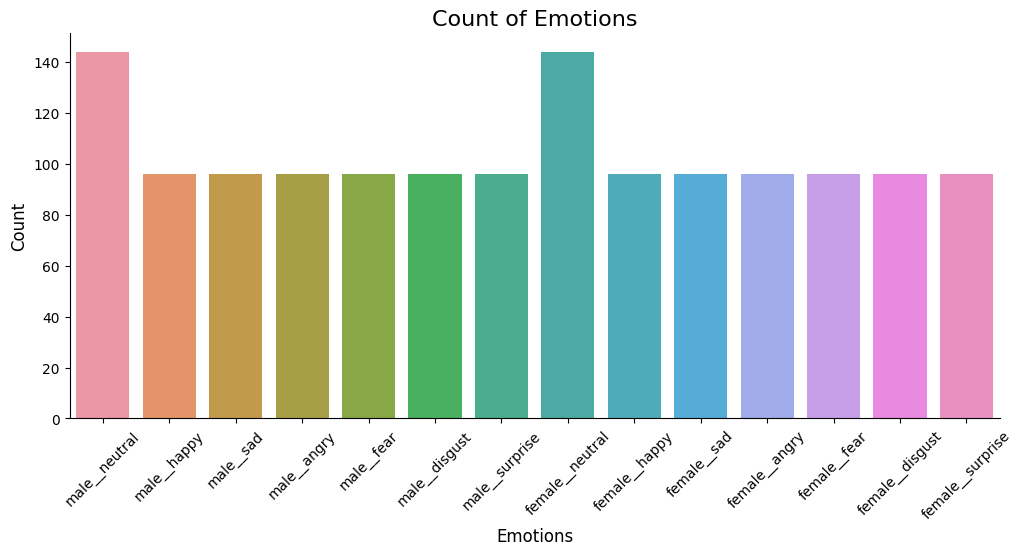

In [5]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(data=RAVD_df, x='labels') 
# ** produced value error when using 'RAVD_df.labels' , 
# struggled with this for hours, but found a fix via friend and ChatGPT :D**
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
mSA3 = RAVD + 'Actor_03/03-01-04-02-01-01-03.wav'
data, sr = librosa.load(mSA3)
ipd.Audio(mSA3)

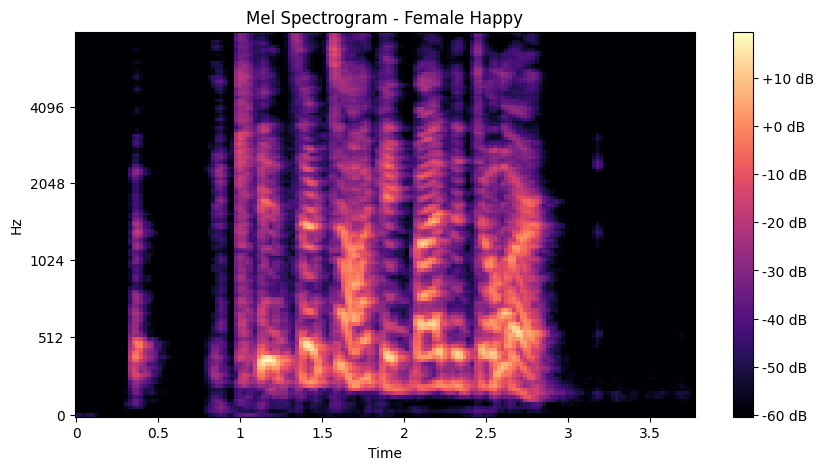

In [7]:
plt.figure(figsize=(10,5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

In [8]:
PATH = 'Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav'

In [9]:
# Gender - Female; Emotion - angry 18

X, sample_rate = librosa.load(PATH, res_type ='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)

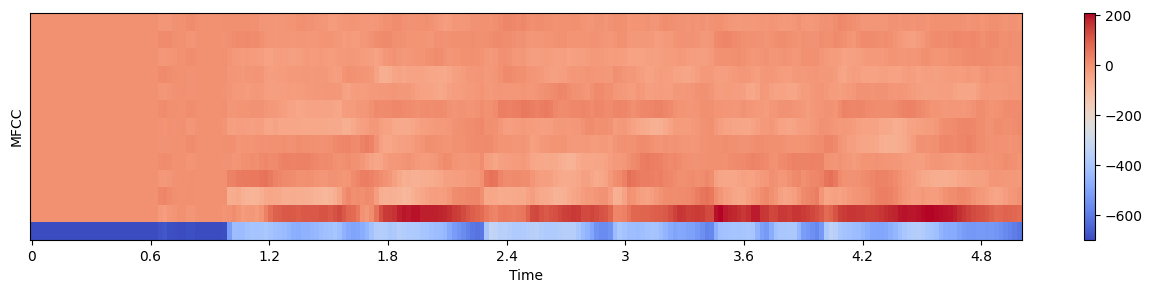

In [10]:
mfcc=librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [11]:
# Gender - Male; Emotion - angry 17

PATH = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(PATH, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

In [12]:
PATH = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav"
x, sample_rate = librosa.load(PATH, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
female = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

216


In [13]:
PATH = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(PATH, res_type='kaiser_fast', duration=2.5, sr=220502*2, offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

216


<function matplotlib.pyplot.legend(*args, **kwargs)>

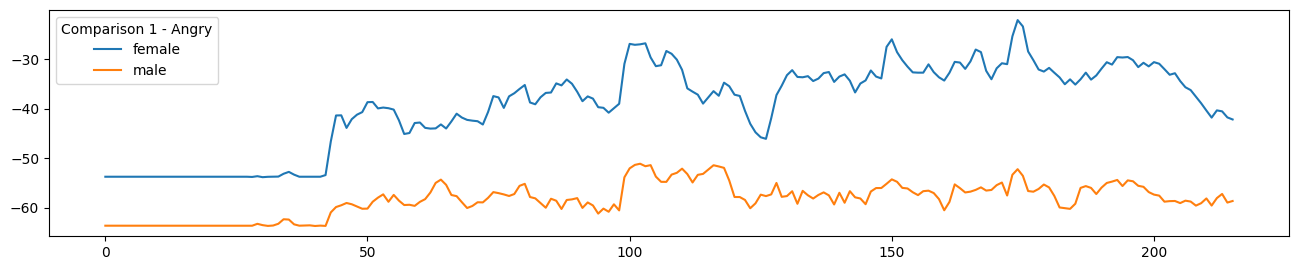

In [14]:
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend(title ='Comparison 1 - Angry')
plt.legend

In [15]:
PATH = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_22/03-01-08-02-01-02-22.wav"

In [16]:
X, sample_rate = librosa.load(PATH, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

216


In [17]:
PATH = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_23/03-01-08-02-01-01-23.wav"
X, sample_rate = librosa.load(PATH, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

216


<function matplotlib.pyplot.legend(*args, **kwargs)>

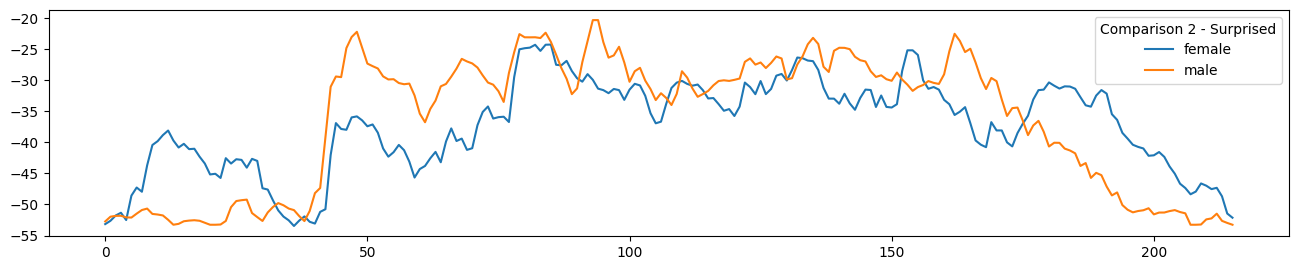

In [18]:
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend(title='Comparison 2 - Surprised')
plt.legend

In [19]:
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

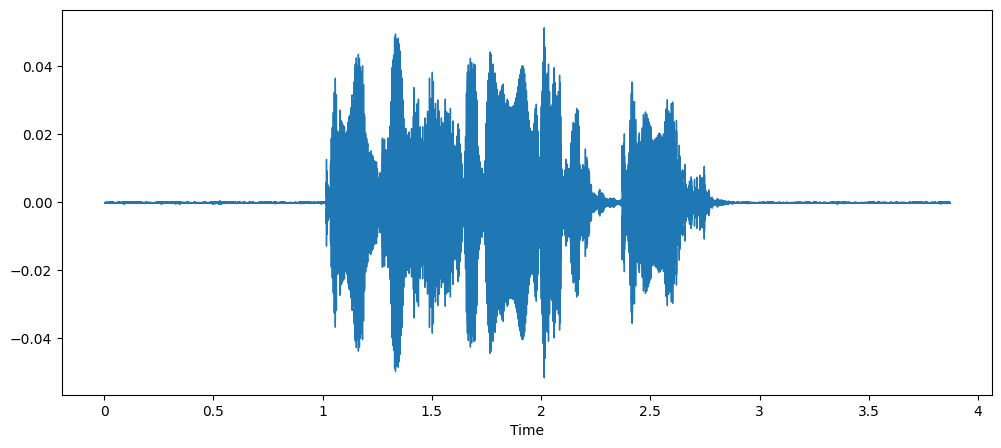

In [20]:
#Normal Audio

plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

In [21]:
# Add noise

def noise(data):
    noise_amp = 0.035*np.random.random()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

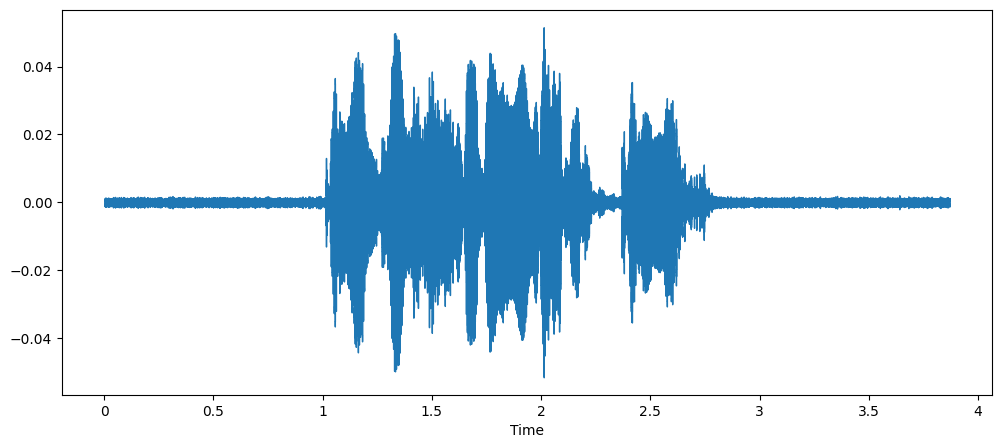

In [22]:
#Audio with noise

x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [23]:
# Stretch 

def stretch(PATH):
    return librosa.effects.time_stretch(data, rate=0.8)

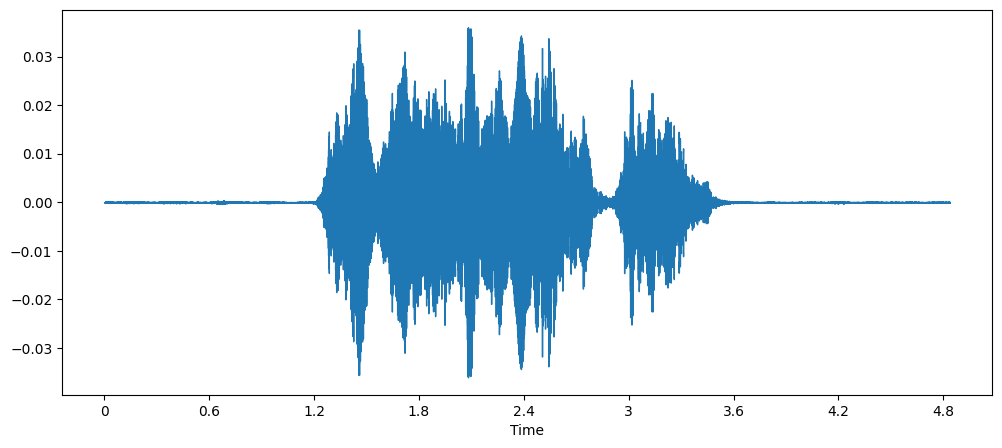

In [24]:
#Stretched audio

x= stretch(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [25]:
# Shift 
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

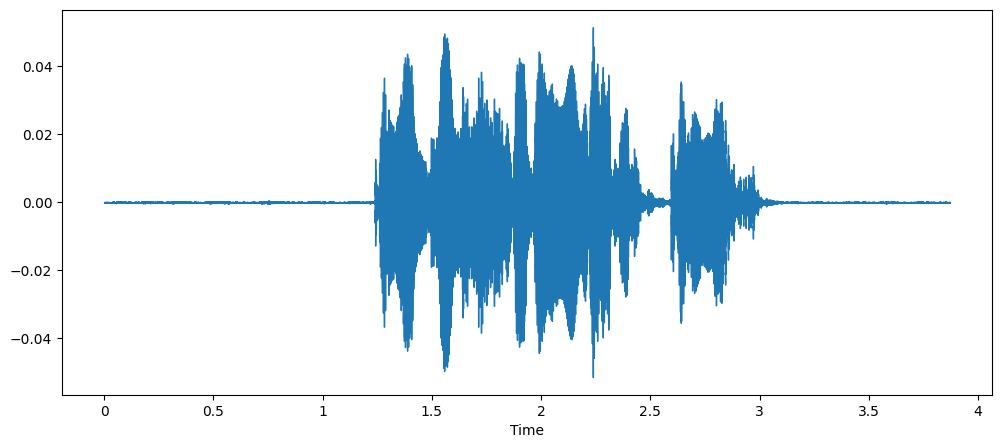

In [26]:
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [27]:
# Pitch

def pitch(data, sr=sr, n_steps=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=0.7)

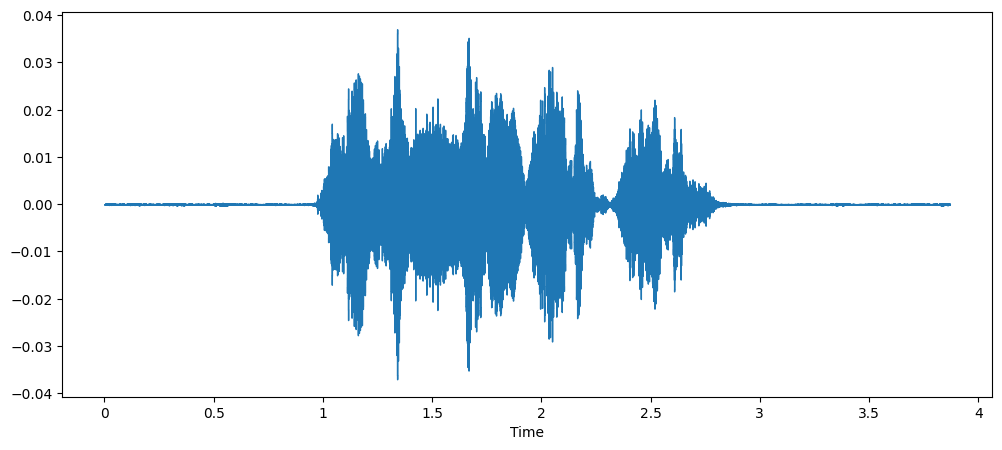

In [28]:
#Audio with pitch

x = pitch(data, sample_rate)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# FEATURE EXTRACTION

##### Using the librosa library, extract mfcc (small set of features, usually about 10–20, which concisely describe the overall shape of a spectral envelope).


In [29]:
def feat_extr(data):
    mfcc=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

In [30]:
def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_extr(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_extr(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_extr(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [31]:
audio_file = "Ravdess-Emotional-Speech-audio-dataset/audio_speech_actors_01-24/Actor_23/03-01-08-02-01-01-23.wav"

In [32]:
RAVD_df.head()
len(RAVD_df)

1440

In [33]:
X, Y = [], []
for path, emotion in tqdm(zip(RAVD_df['path'], RAVD_df['labels'])):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

1440it [04:41,  5.11it/s]


In [34]:
Emotions = pd.DataFrame(X)
Emotions['labels']=Y
Emotions.to_csv('emotions.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841306,16.399446,10.241591,0.653901,-4.328002,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male__neutral
1,-450.228431,31.522969,8.573122,10.067214,5.908555,-0.164325,-3.696431,-6.772416,-9.778881,-5.863171,...,-1.417419,-1.383985,-1.824974,-1.402961,-0.489462,-3.338665,-2.636589,0.070902,-2.773936,male__neutral
2,-687.067749,46.238098,9.856143,10.340695,2.371954,-6.251415,-7.108812,-8.698574,-1.229081,-2.309932,...,5.107841,-5.782943,-0.850573,-3.217227,-1.408437,-1.237480,0.292667,-2.185367,-0.348755,male__neutral
3,-634.663269,72.324066,-2.998578,20.209740,10.674218,-1.151011,-2.813591,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719306,-4.954944,-0.688254,0.114427,-6.475232,-1.695711,-2.899729,0.377745,male__neutral
4,-489.468046,38.730910,6.085128,12.735761,6.182263,-1.748186,-2.882327,-8.190474,-10.823171,-5.078523,...,-2.576651,-1.599936,-3.116333,-1.582851,-0.890460,-4.549656,-3.054218,-0.383762,-1.903956,male__neutral


In [35]:
# From saved feature .csv
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841306,16.399446,10.241591,0.653901,-4.328002,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male_neutral
1,-481.762278,38.944346,6.982880,10.147249,5.726315,-0.987589,-4.292984,-7.121031,-10.564381,-6.640772,...,-2.626597,-1.748426,-1.881672,-1.134053,-0.522587,-4.098455,-3.567485,-0.454192,-2.790784,male_neutral
2,-712.554077,70.982697,-0.730811,16.815830,7.990943,-0.822050,-6.391445,-6.146833,-15.975615,-0.313742,...,-3.398211,2.348455,-6.031178,1.242808,-1.837245,-5.671288,-3.115946,-1.071852,-4.964334,male_neutral
3,-634.663269,72.324066,-2.998578,20.209740,10.674218,-1.151011,-2.813591,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719306,-4.954944,-0.688254,0.114427,-6.475232,-1.695711,-2.899729,0.377745,male_neutral
4,-475.775992,35.223625,7.258520,12.820706,6.668910,-1.598881,-3.630649,-7.850035,-10.090502,-4.536523,...,-1.971660,-1.416455,-3.079286,-1.580273,-0.184796,-4.138279,-2.790208,-0.459383,-2.887019,male_neutral


## Data Preprocessing

In [36]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [37]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

## Train Test Split

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 20), (3024, 14), (1296, 20), (1296, 14))

In [39]:
# reshape for LSTM 

X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [40]:
# Scaling  data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3024, 20), (3024, 14), (1296, 20), (1296, 14))

## LSTM Model

In [41]:
model01=Sequential()
model01.add(LSTM(70,return_sequences=True,input_shape=(20,1))) #1
model01.add(LSTM(50,return_sequences=True)) #2 
model01.add(LSTM(60)) #3
model01.add(Dense(48, activation='relu'))
model01.add(Dense(14)) #4
model01.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy']) #5

model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 70)            20160     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            24200     
                                                                 
 lstm_2 (LSTM)               (None, 60)                26640     
                                                                 
 dense (Dense)               (None, 48)                2928      
                                                                 
 dense_1 (Dense)             (None, 14)                686       
                                                                 
Total params: 74,614
Trainable params: 74,614
Non-trainable params: 0
_________________________________________________________________


In [49]:
lstm = model01.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=28, verbose=1)

Epoch 1/50
108/108 [==============================] - 20s 29ms/step - loss: 0.0630 - accuracy: 0.2371 - val_loss: 0.0612 - val_accuracy: 0.2701
Epoch 2/50
108/108 [==============================] - 2s 19ms/step - loss: 0.0604 - accuracy: 0.2791 - val_loss: 0.0595 - val_accuracy: 0.2747
Epoch 3/50
108/108 [==============================] - 2s 21ms/step - loss: 0.0595 - accuracy: 0.2970 - val_loss: 0.0593 - val_accuracy: 0.2924
Epoch 4/50
108/108 [==============================] - 2s 20ms/step - loss: 0.0584 - accuracy: 0.3148 - val_loss: 0.0584 - val_accuracy: 0.3002
Epoch 5/50
108/108 [==============================] - 2s 21ms/step - loss: 0.0575 - accuracy: 0.3386 - val_loss: 0.0581 - val_accuracy: 0.3079
Epoch 6/50
108/108 [==============================] - 2s 21ms/step - loss: 0.0567 - accuracy: 0.3353 - val_loss: 0.0579 - val_accuracy: 0.3164
Epoch 7/50
108/108 [==============================] - 2s 19ms/step - loss: 0.0563 - accuracy: 0.3495 - val_loss: 0.0578 - val_accuracy: 0.324

In [50]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")

41/41 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.5949
Accuracy of our model on test data :  59.49074029922485 %


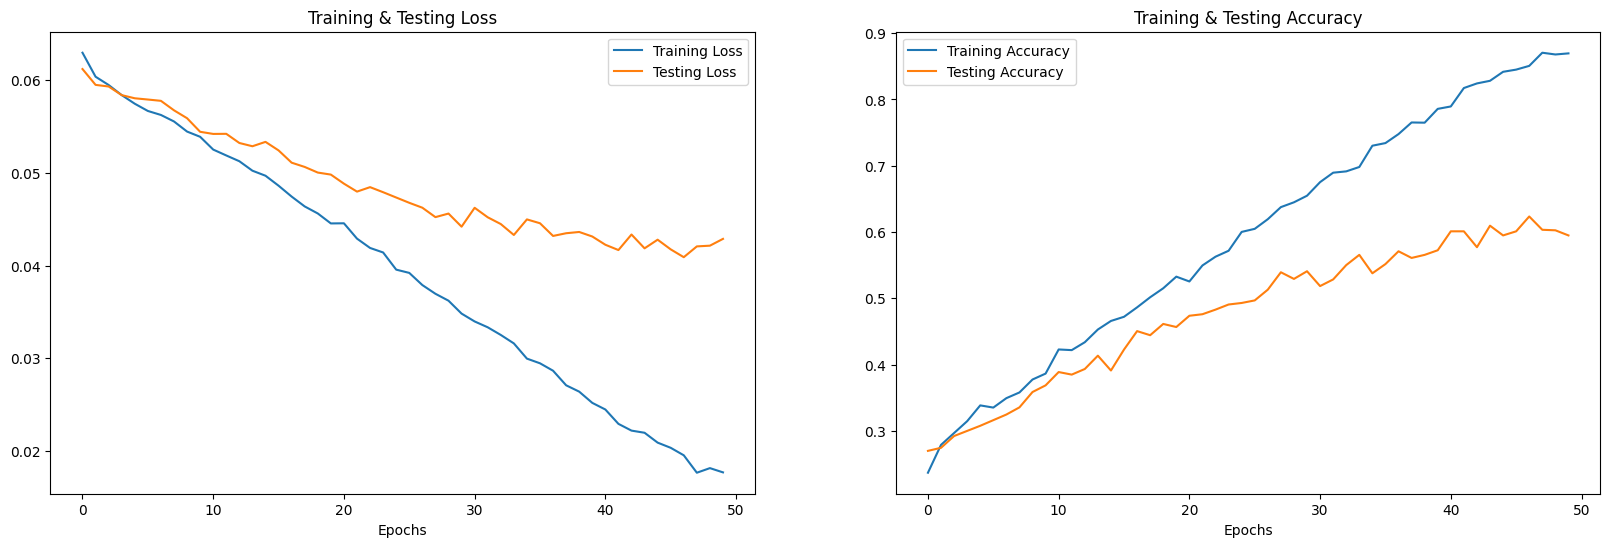

In [51]:
 # Loss Accuracy Plot Using CNN
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = lstm.history['accuracy']
train_loss = lstm.history['loss']
test_acc = lstm.history['val_accuracy']
test_loss = lstm.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

LSTM11:
###### HIGHEST ACC: 87%
###### HIGHEST TEST ACC: 60%

## CNN Model

In [42]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3024, 20, 1), (3024, 14), (1296, 20, 1), (1296, 14))

#### CNN only 

###### Batch size = 28, 100 epochs, CNN only, no LSTM

###### training acc = 97% 
###### test acc = 64%

In [43]:
def construct_model():
    model = Sequential()
    model.add(Conv1D(1024, 2, strides=1, activation='relu', input_shape=(x_traincnn.shape[1], 1)))
    model.add(Conv1D(512, 2, strides=1, activation='relu', input_shape=(x_traincnn.shape[1], 1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 2, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 2, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(14, activation='softmax'))

    model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])

    model.summary()
    return model

In [44]:
import visualkeras
from PIL import ImageFont

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 19, 1024)          3072      
                                                                 
 conv1d_25 (Conv1D)          (None, 18, 512)           1049088   
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 9, 512)           0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 8, 256)            262400    
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 4, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 3, 128)           

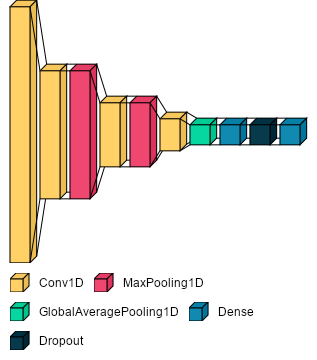

In [51]:
model = construct_model()
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, scale_xy=0.25, font=font, legend=True)


In [54]:
history = model.fit(x_traincnn, y_train, batch_size=28, epochs=100
                    , validation_data=(x_testcnn, y_test))

Epoch 1/100
108/108 [==============================] - 6s 52ms/step - loss: 0.0642 - accuracy: 0.1720 - val_loss: 0.0624 - val_accuracy: 0.2014
Epoch 2/100
108/108 [==============================] - 5s 50ms/step - loss: 0.0622 - accuracy: 0.2325 - val_loss: 0.0612 - val_accuracy: 0.2276
Epoch 3/100
108/108 [==============================] - 5s 49ms/step - loss: 0.0608 - accuracy: 0.2642 - val_loss: 0.0589 - val_accuracy: 0.2955
Epoch 4/100
108/108 [==============================] - 5s 51ms/step - loss: 0.0586 - accuracy: 0.3092 - val_loss: 0.0569 - val_accuracy: 0.3302
Epoch 5/100
108/108 [==============================] - 5s 49ms/step - loss: 0.0554 - accuracy: 0.3565 - val_loss: 0.0559 - val_accuracy: 0.3441
Epoch 6/100
108/108 [==============================] - 5s 50ms/step - loss: 0.0539 - accuracy: 0.3710 - val_loss: 0.0536 - val_accuracy: 0.3866
Epoch 7/100
108/108 [==============================] - 5s 51ms/step - loss: 0.0498 - accuracy: 0.4352 - val_loss: 0.0511 - val_accuracy:

108/108 [==============================] - 5s 50ms/step - loss: 0.0068 - accuracy: 0.9408 - val_loss: 0.0439 - val_accuracy: 0.6219
Epoch 58/100
108/108 [==============================] - 5s 51ms/step - loss: 0.0068 - accuracy: 0.9395 - val_loss: 0.0432 - val_accuracy: 0.6304
Epoch 59/100
108/108 [==============================] - 6s 52ms/step - loss: 0.0059 - accuracy: 0.9497 - val_loss: 0.0460 - val_accuracy: 0.6057
Epoch 60/100
108/108 [==============================] - 5s 50ms/step - loss: 0.0074 - accuracy: 0.9358 - val_loss: 0.0456 - val_accuracy: 0.6150
Epoch 61/100
108/108 [==============================] - 6s 51ms/step - loss: 0.0065 - accuracy: 0.9418 - val_loss: 0.0454 - val_accuracy: 0.6073
Epoch 62/100
108/108 [==============================] - 5s 50ms/step - loss: 0.0080 - accuracy: 0.9286 - val_loss: 0.0455 - val_accuracy: 0.6188
Epoch 63/100
108/108 [==============================] - 5s 49ms/step - loss: 0.0065 - accuracy: 0.9421 - val_loss: 0.0449 - val_accuracy: 0.618

In [55]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

41/41 [==============================] - 1s 13ms/step - loss: 0.0489 - accuracy: 0.6080
Accuracy of our model on test data :  60.80247163772583 %


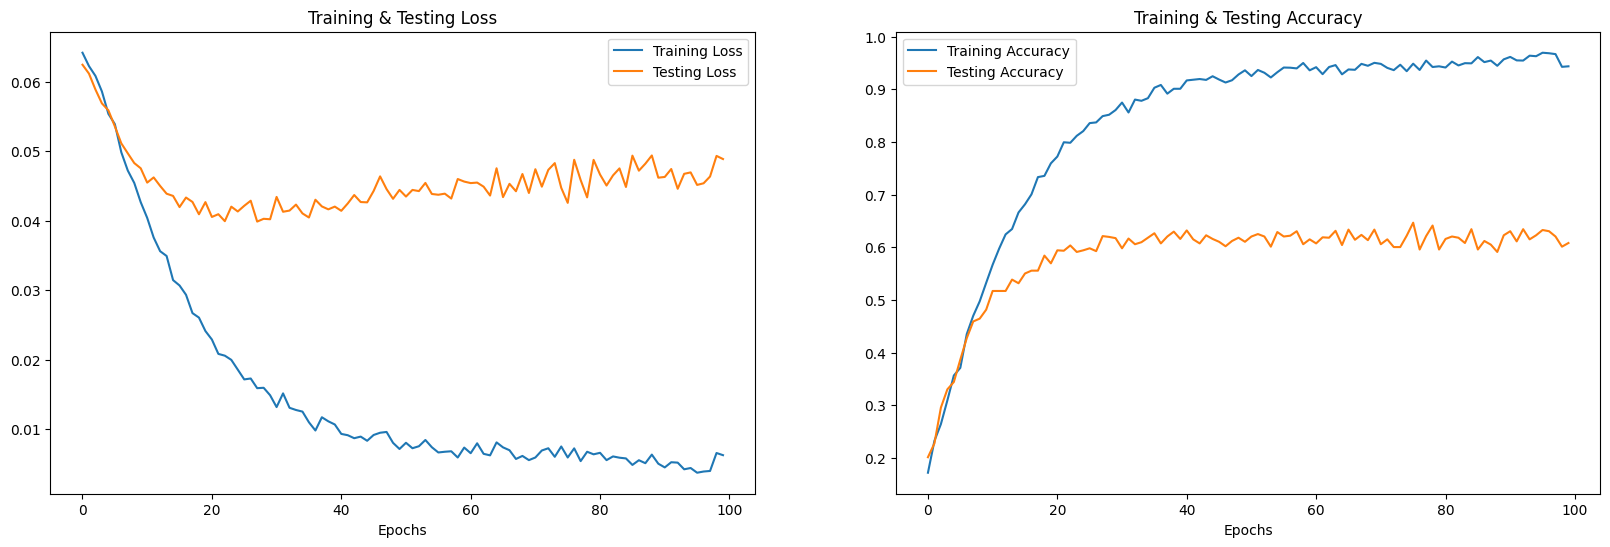

In [56]:
 # Loss Accuracy Plot Using CNN
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [53]:
def cconstruct_model2():
    model2 = Sequential()
    model2.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
    model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
    model2.add(BatchNormalization())

    model2.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
    model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
    model2.add(BatchNormalization())

    model2.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
    model2.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
    model2.add(BatchNormalization())

    model2.add(LSTM(256, return_sequences=True))

    model2.add(LSTM(128))

    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(0.5))

    model2.add(Dense(64, activation='relu'))
    model2.add(Dropout(0.5))

    model2.add(Dense(32, activation='relu'))
    model2.add(Dropout(0.2))

    model2.add(Dense(14, activation='softmax'))

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model2.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model2.summary()
    return model2

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 20, 2048)          12288     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 10, 2048)         0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 10, 2048)         8192      
 hNormalization)                                                 
                                                                 
 conv1d_32 (Conv1D)          (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 5, 1024)          0         
 g1D)                                                            
                                                      

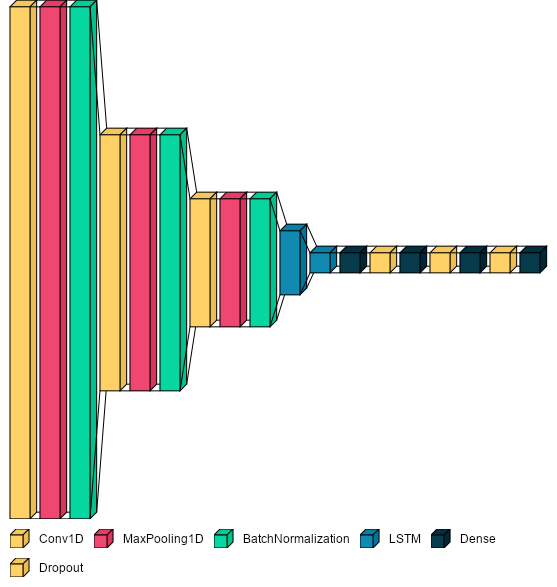

In [54]:
model2 = cconstruct_model2()
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model2, scale_xy=0.25, font=font, legend=True)

In [ ]:
history2 = model2.fit(x_traincnn, y_train, batch_size=28, epochs=100
                    , validation_data=(x_testcnn, y_test))

Epoch 1/100
108/108 [==============================] - 141s 1s/step - loss: 2.6033 - accuracy: 0.1098 - val_loss: 2.6278 - val_accuracy: 0.0995
Epoch 2/100
108/108 [==============================] - 131s 1s/step - loss: 2.5410 - accuracy: 0.1468 - val_loss: 2.6068 - val_accuracy: 0.1150
Epoch 3/100
108/108 [==============================] - 130s 1s/step - loss: 2.4704 - accuracy: 0.1799 - val_loss: 2.5388 - val_accuracy: 0.1103
Epoch 4/100
108/108 [==============================] - 129s 1s/step - loss: 2.3828 - accuracy: 0.2100 - val_loss: 2.5080 - val_accuracy: 0.1968
Epoch 5/100
108/108 [==============================] - 133s 1s/step - loss: 2.2643 - accuracy: 0.2440 - val_loss: 2.2008 - val_accuracy: 0.2801
Epoch 6/100
108/108 [==============================] - 132s 1s/step - loss: 2.1594 - accuracy: 0.2765 - val_loss: 2.0231 - val_accuracy: 0.3333
Epoch 7/100
108/108 [==============================] - 133s 1s/step - loss: 2.0747 - accuracy: 0.2890 - val_loss: 1.9250 - val_accuracy:

In [ ]:
h1 = print(highest_train_acc)
h2 =print(highest_test_acc)

In [ ]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
#SAVING THE MODEL

model_name = 'model3.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)